In [206]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, cv, Pool
from sklearn.metrics import root_mean_squared_error, make_scorer, mean_absolute_percentage_error
from sklearn.feature_selection import r_regression
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",None)

In [207]:
df_1 = pd.read_json('DATASET_FINAL.json')

df = df_1.copy()

In [208]:
# Groupement des acteur 1, 2, 3 , scénaristes, réalisateurs, et distributeurs qui font plus de 500k entrée 


df_actor_1 = df.groupby('actor_1')['weekly_entrances'].mean().reset_index()
df_actor_1= df_actor_1[df_actor_1['weekly_entrances']>500000].sort_values(by = 'weekly_entrances', ascending=False)

df_actor_2 = df.groupby('actor_2')['weekly_entrances'].mean().reset_index()
df_actor_2 = df_actor_2[df_actor_2['weekly_entrances']>500000].sort_values(by = 'weekly_entrances', ascending=False)

df_actor_3 = df.groupby('actor_3')['weekly_entrances'].mean().reset_index()
df_actor_3 = df_actor_3[df_actor_3['weekly_entrances']>500000].sort_values(by = 'weekly_entrances', ascending=False)

df_directors = df.groupby('directors')['weekly_entrances'].mean().reset_index()
df_directors = df_directors[df_directors['weekly_entrances']>500000].sort_values(by = 'weekly_entrances', ascending=False)

df_writer = df.groupby('writer')['weekly_entrances'].mean().reset_index()
df_writer = df_writer[df_writer['weekly_entrances']>500000].sort_values(by = 'weekly_entrances', ascending=False)

df_distribution = df.groupby('distribution')['weekly_entrances'].mean().reset_index()
df_distribution = df_distribution[df_distribution['weekly_entrances']>500000].sort_values(by = 'weekly_entrances', ascending=False)



In [209]:



df['top_actor_1'] = df['actor_1'].apply(lambda x : 1 if x in(df_actor_1['actor_1'].to_list()
) else 0)

df['top_actor_2'] = df['actor_2'].apply(lambda x : 1 if x in(df_actor_2['actor_2'].to_list()
) else 0)


df['top_actor_3'] = df['actor_3'].apply(lambda x : 1 if x in(df_actor_3['actor_3'].to_list()
) else 0)

df['top_director'] = df['directors'].apply(lambda x : 1 if x in(df_directors['directors'].to_list()
) else 0)

df['top_writer'] = df['writer'].apply(lambda x : 1 if x in(df_writer['writer'].to_list()
) else 0)



df['top_distribution'] = df['distribution'].apply(lambda x : 1 if x in(df_distribution['distribution'].to_list()
) else 0)


In [210]:
df.dtypes

fr_title            object
released_year        int64
directors           object
writer              object
distribution        object
country             object
budget               int64
category            object
released_date       object
classification      object
duration            object
weekly_entrances     int64
duration_minutes     int64
actor_1             object
actor_2             object
actor_3             object
top_actor_1          int64
top_actor_2          int64
top_actor_3          int64
top_director         int64
top_writer           int64
top_distribution     int64
dtype: object

In [211]:
features_of_interest = [
    # "actor_1",
    # "actor_2",
    # 'actor_3',
    # "directors",
    #  "writer",
    # "distribution",
    'released_year',
    "country",
    "budget",
    'category',
    'classification',
    'duration_minutes', 
    "top_actor_1",
    "top_actor_2",
    "top_actor_3",
    "top_director",
    'top_writer',
    'top_distribution'
]


numerical_column = [
    "budget",
    'released_year',
    "duration_minutes",
]


ordinal_column = [
    "top_actor_1",
    "top_actor_2",
    "top_actor_3",
    "top_director",
    'top_writer',
    'top_distribution'
]

categorical_column = [
        # "actor_1",
        # "actor_2",
        # "actor_3",
        # "directors",
        # "writer",
        # "distribution",
    "country",
    'category',
    'classification',
]


target_name = "weekly_entrances"
data, target, numerical_data,categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[categorical_column]
)


In [212]:
X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True, train_size=0.85, random_state=42)

In [213]:
X_train.dtypes

released_year        int64
country             object
budget               int64
category            object
classification      object
duration_minutes     int64
top_actor_1          int64
top_actor_2          int64
top_actor_3          int64
top_director         int64
top_writer           int64
top_distribution     int64
dtype: object

In [222]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("numeric", RobustScaler(), numerical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column)
    ],
    remainder="passthrough",
)

catboost_model = make_pipeline(preprocessor, CatBoostRegressor())
catboost_model.fit(X_train,y_train)

# Prédictions sur le test
y_pred = catboost_model.predict(X_test)

# Calcul des métriques
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
errors = y_pred - y_test
sum_errors = np.sum(errors)
mean_errors = np.mean(errors)
print(f"✅ RMSE (test) Catboost: {rmse:.4f}")
print(f"✅ MAPE (test) Catboost: {mape:.4f}")
print(f"🔥 Somme des erreurs: {sum_errors:.4f}")
print(f"🔥 moyenne des erreurs: {mean_errors:.4f}")

Learning rate set to 0.054572
0:	learn: 332310.2982305	total: 1.5ms	remaining: 1.5s
1:	learn: 322530.8658272	total: 2.74ms	remaining: 1.37s
2:	learn: 312783.6323176	total: 4.26ms	remaining: 1.42s
3:	learn: 303618.2425083	total: 5.53ms	remaining: 1.38s
4:	learn: 295056.5723214	total: 6.65ms	remaining: 1.32s
5:	learn: 287657.3237923	total: 7.85ms	remaining: 1.3s
6:	learn: 279854.1428022	total: 9.03ms	remaining: 1.28s
7:	learn: 273026.3062969	total: 10.2ms	remaining: 1.27s
8:	learn: 266860.2124631	total: 11.5ms	remaining: 1.26s
9:	learn: 260941.8985221	total: 12.4ms	remaining: 1.23s
10:	learn: 255252.0160601	total: 13.6ms	remaining: 1.22s
11:	learn: 250254.2420495	total: 14.9ms	remaining: 1.23s
12:	learn: 245785.7621109	total: 16ms	remaining: 1.22s
13:	learn: 241586.3971465	total: 18.4ms	remaining: 1.29s
14:	learn: 237508.0433374	total: 19.6ms	remaining: 1.29s
15:	learn: 233644.3006435	total: 20.8ms	remaining: 1.28s
16:	learn: 230047.1513042	total: 21.9ms	remaining: 1.26s
17:	learn: 22668

In [223]:
import pandas as pd
import numpy as np

# Étape 1 : Extraire le modèle CatBoost et le préprocessor depuis le pipeline
fitted_preprocessor = catboost_model.named_steps["columntransformer"]
fitted_model = catboost_model.named_steps["catboostregressor"]

# Étape 2 : Récupérer tous les noms de features après transformation
# - Categorical (OneHotEncoder)
cat_feat_names = fitted_preprocessor.named_transformers_["categorical"]\
    .get_feature_names_out(categorical_column)

# - Numeric (RobustScaler)
num_feat_names = numerical_column

# - Ordinal (OrdinalEncoder)
ord_feat_names = ordinal_column

# - Autres (remainder passthrough)
# Ici on a rien en plus, donc on concatène
feature_names = np.concatenate([cat_feat_names, num_feat_names, ord_feat_names])

# Étape 3 : Récupérer les importances du modèle
importances = fitted_model.feature_importances_

# Étape 4 : Créer un DataFrame trié avec noms + importances
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("📊 Feature Importances (top 30) :")
print(feat_imp_df.head(30))

# Étape 5 : Somme des valeurs d'origine pour chaque colonne d'intérêt
print("\n🧮 Sommes des valeurs par feature (dans les données brutes) :")

for col in numerical_column + ordinal_column:
    print(f"{col:25}: {df[col].sum():,.0f}")


📊 Feature Importances (top 30) :
                              Feature  Importance
101                            budget   18.514385
108                        top_writer   16.163204
106                       top_actor_3   10.051847
103                  duration_minutes    8.587160
107                      top_director    7.386706
105                       top_actor_2    7.338087
104                       top_actor_1    7.046726
102                     released_year    6.405972
26                     country_France    4.802597
77                   category_Comédie    2.877358
82                   category_Fantasy    1.747168
109                  top_distribution    1.494294
24                 country_Etats-Unis    1.323403
74         category_Aventure - Action    0.894650
100        classification_Tout public    0.893597
99    classification_Interdit - 8 ans    0.781295
90           category_Science Fiction    0.550723
76                 category_Comicbook    0.520299
81               

In [224]:
items_list = feat_imp_df['Feature'].unique()
to_remove = ['budget', 'top_writer', 'duration_minutes', 'top_actor_3',
             'top_actor_1', 'top_actor_2', 'top_director']

items_list = [item for item in items_list if item not in to_remove]

for category in categorical_column:

    list_sum = 0
    to_drop = []

    for cat in items_list:
        if category in cat:
            list_sum += feat_imp_df.loc[feat_imp_df['Feature'] == cat, 'Importance'].values[0]
            to_drop.append(cat)

    feat_imp_df = feat_imp_df[~feat_imp_df['Feature'].isin(to_drop)]

    new_row = pd.DataFrame([{'Feature': category, 'Importance': list_sum}])
    feat_imp_df = pd.concat([feat_imp_df, new_row], axis=0, ignore_index=True)

    print(f'la somme de {category} est de {list_sum}')

# Affichage final
feat_imp_df


la somme de country est de 6.358469400683433
la somme de category est de 8.209292096712081
la somme de classification est de 2.4438584644661465


,Feature,Importance
0,budget,18.514385
1,top_writer,16.163204
2,top_actor_3,10.051847
3,duration_minutes,8.587160
4,top_director,7.386706
5,top_actor_2,7.338087
6,top_actor_1,7.046726
7,released_year,6.405972
8,top_distribution,1.494294
9,country,6.358469


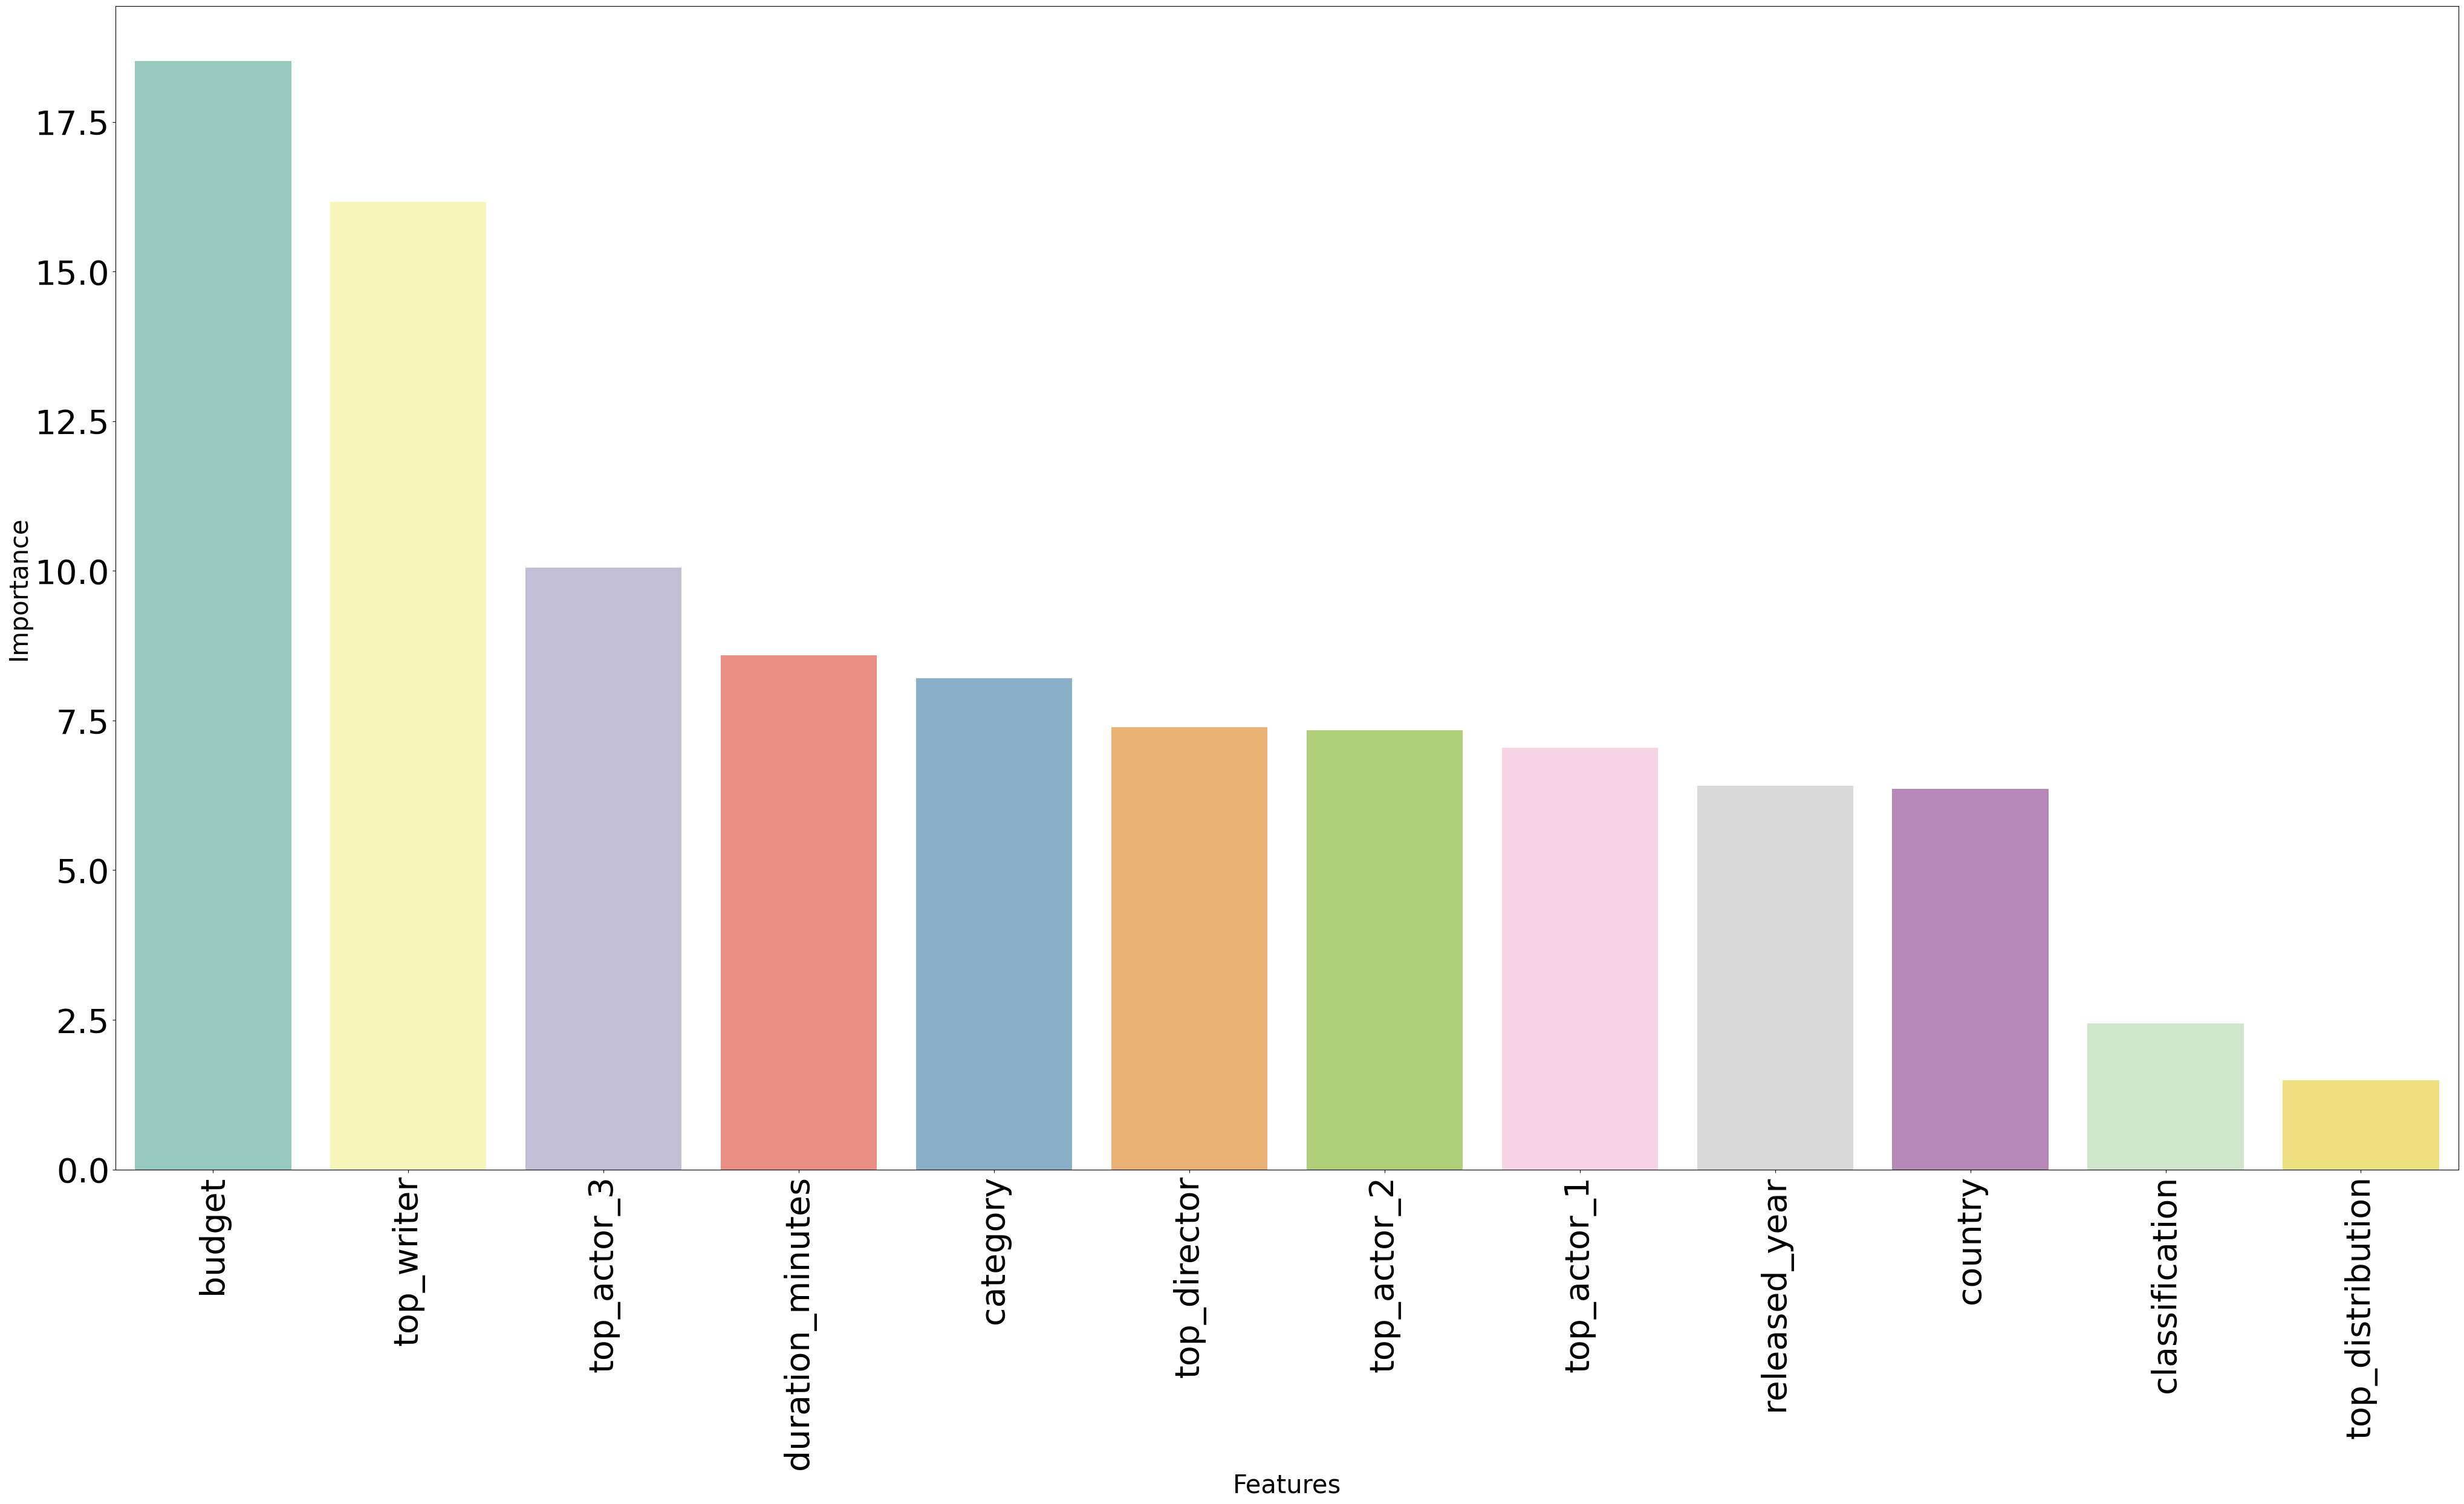

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 25))
sns.barplot(data=feat_imp_df.sort_values(by = 'Importance', ascending=False), x="Feature", y="Importance", palette="Set3")

# Labels axes
plt.xlabel("Features", fontsize=30)
plt.ylabel("Importance", fontsize=30)

# Taille des ticks
plt.tick_params(axis='both', labelsize=40)

# Rotation des labels en x si besoin (sinon tout se chevauche)
plt.xticks(rotation=90)

plt.show()


In [ ]:
df.columns

Index(['fr_title', 'released_year', 'directors', 'writer', 'distribution',
       'country', 'budget', 'category', 'released_date', 'classification',
       'duration', 'weekly_entrances', 'duration_minutes', 'actor_1',
       'actor_2', 'actor_3', 'top_actor_1', 'top_actor_2', 'top_actor_3',
       'top_director', 'top_writer', 'top_distribution'],
      dtype='object')

In [ ]:
from scipy.stats import f_oneway
# Exemple de dataframe df_2_anova
df_2_anova = df.copy()



# Boucle sur les colonnes discrètes
for column in df_2_anova.columns:
    if column != 'weekly_entrances':  # On ne veut pas tester 'weekly_entrances' avec lui-même
        # Créer les groupes selon les valeurs de la colonne discrète
        groups = [df_2_anova[df_2_anova[column] == category]['weekly_entrances']
                  for category in df_2_anova[column].dropna().unique()]
        
        # Appliquer le test ANOVA
        stat_anova, p_value = f_oneway(*groups)
        
#         # # Si l'ANOVA est significative (p-value < 0.05), on applique Tukey HSD
#         # if p_value < 0.05:
#         #     # Appliquer le test post-hoc Tukey
#         #     tukey_result = pairwise_tukeyhsd(df_2_anova['weekly_entrances'], df_2_anova[column])
#         #     print(f'Post-hoc Tukey HSD pour {column}:\n', tukey_result.summary())
        
        # Afficher les résultats de l'ANOVA
        print(f'Le résultat pour {column}')
        print("Statistique F:", stat_anova)
        print("P-value:", p_value)
        print('')
        print('================================================================================')


Le résultat pour fr_title
Statistique F: 0.41652693718026995
P-value: 0.9812119563987682

Le résultat pour released_year
Statistique F: 2.9749048311426027
P-value: 1.238115635759097e-10

Le résultat pour directors
Statistique F: 1.5050970011166196
P-value: 5.003036662965276e-35

Le résultat pour writer
Statistique F: 1.4075260181823717
P-value: 8.499730665818995e-24

Le résultat pour distribution
Statistique F: 1.8537591589219735
P-value: 2.0056444949755333e-47

Le résultat pour country
Statistique F: 8.190931457293624
P-value: 1.9089757537287267e-78

Le résultat pour budget
Statistique F: 6.059394708134451
P-value: 0.0

Le résultat pour category
Statistique F: 80.04295805884722
P-value: 5.5e-321

Le résultat pour released_date
Statistique F: 1.0304036874940778
P-value: 0.22050756662100437

Le résultat pour classification
Statistique F: 44.530970788712395
P-value: 8.94625648115363e-54

Le résultat pour duration
Statistique F: 6.1697091752479984
P-value: 9.214400333780716e-108

Le résul

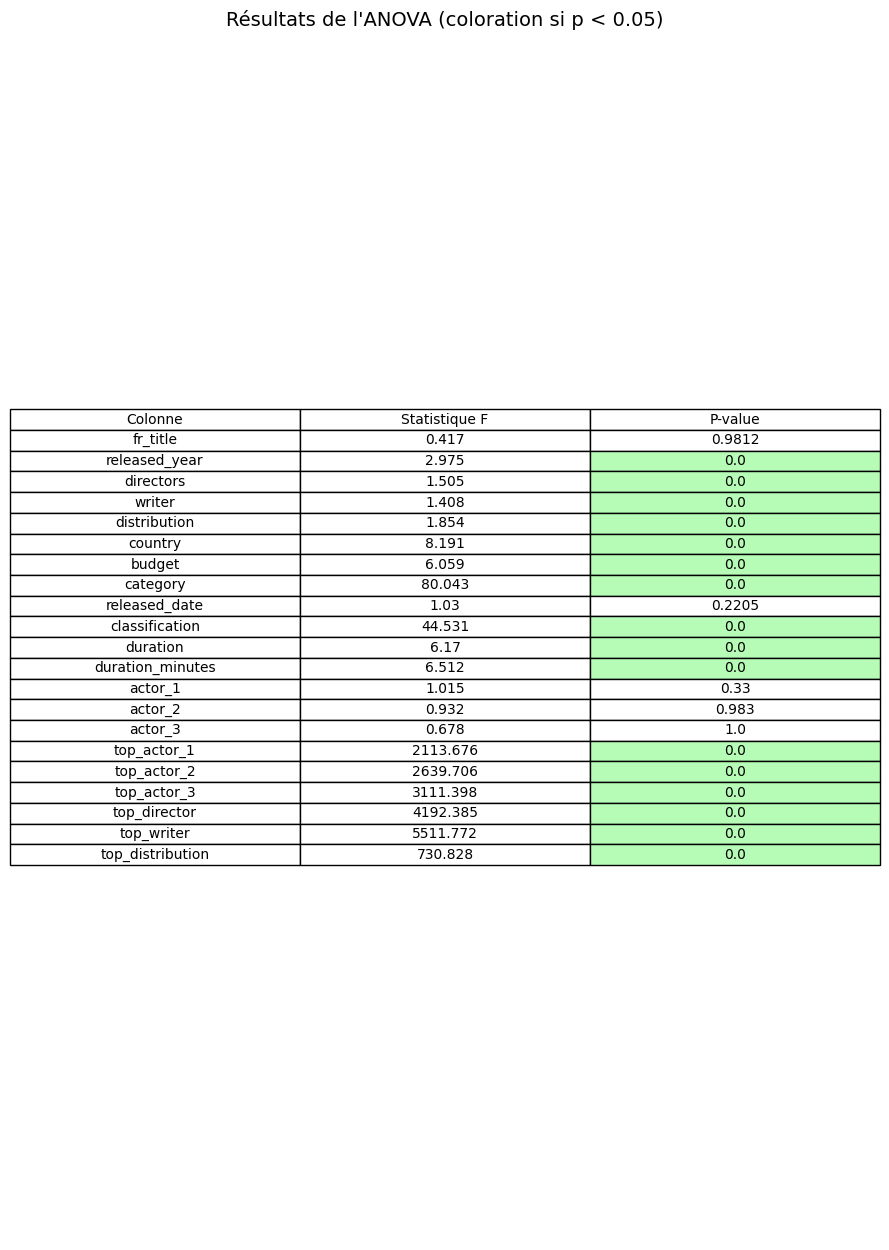

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway

# Exemple de dataframe df_2_anova
df_2_anova = df.copy()

# Liste pour stocker les résultats
results = []

# Boucle sur les colonnes discrètes
for column in df_2_anova.columns:
    if column != 'weekly_entrances':
        groups = [df_2_anova[df_2_anova[column] == category]['weekly_entrances']
                  for category in df_2_anova[column].dropna().unique()]
        
        stat_anova, p_value = f_oneway(*groups)
        results.append([column, round(stat_anova, 3), round(p_value, 4)])  # arrondi pour lisibilité

# Créer DataFrame
results_df = pd.DataFrame(results, columns=['Colonne', 'Statistique F', 'P-value'])

# Création du tableau matplotlib
fig, ax = plt.subplots(figsize=(9, len(results_df)*0.6))
ax.axis('off')
ax.axis('tight')

# Création du tableau
table = ax.table(cellText=results_df.values,
                 colLabels=results_df.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center')

# Appliquer une couleur conditionnelle si p-value < 0.05
for i in range(len(results_df)):
    p_val = results_df.loc[i, 'P-value']
    if p_val < 0.05:
        # Colorier la cellule de la p-value en vert pâle
        table[(i+1, 2)].set_facecolor('#b6fcb6')  # Vert pâle

# Titre
plt.title('Résultats de l\'ANOVA (coloration si p < 0.05)', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
data.columns

Index(['released_year', 'country', 'budget', 'category', 'classification',
       'duration_minutes', 'top_actor_1', 'top_actor_2', 'top_actor_3',
       'top_director', 'top_writer', 'top_distribution'],
      dtype='object')

In [ ]:
data.classification.unique()

array(['Tout public', 'Interdit - 10 ans', 'Interdit - 6 ans',
       'Interdit - 8 ans', 'Interdit - 12 ans', 'Interdit - 16 ans',
       'Interdit - 18 ans'], dtype=object)

In [ ]:
data.category.unique()

array(['Comédie', 'Science Fiction', 'Comicbook', 'Fantasy',
       'Aventure - Action', 'Guerre', 'Animation', 'Drame', 'Western',
       'Comédie dramatique', 'Thriller', 'Péplum', 'Musical',
       'Film familial', 'Romance', 'Horreur', 'Documentaire',
       'Catastrophe', 'X - Erotique', 'Adaptation Livre', 'Court-métrage',
       'Parodie', 'Action'], dtype=object)

In [ ]:
df_1.columns

Index(['fr_title', 'released_year', 'directors', 'writer', 'distribution',
       'country', 'budget', 'category', 'released_date', 'classification',
       'duration', 'weekly_entrances', 'duration_minutes', 'actor_1',
       'actor_2', 'actor_3'],
      dtype='object')

In [ ]:
import pandas as pd

# Exemple : colonnes que ton modèle attend (à adapter si besoin)
columns = [
    df_1.columns
]

# Créer un DataFrame vide avec les bonnes colonnes
df_template_test = pd.DataFrame(columns=columns)



# Ajouter un exemple de ligne (ou plusieurs)
df_1_test_film = pd.DataFrame({['fr_title' : "sinners",
                                'released_year': 2025,
                                'directors':"Ryan Coogler", 
                                'writer':"Ryan Coogler", 
                                'distribution':'Universal Pictures International France',
                                'country':'Etats-Unis',
                                 'budget': 90000000,
                                  'category':'Aventure - Action', 
                                  'released_date':"16/04/2025", 
                                  'classification':'Interdit - 12 ans',                               
                                'duration':"2h 17min", 
                                'weekly_entrances': "", 
                                'duration_minutes':137, 
                                'actor_1': "Michael B. Jordan",
                                'actor_2': "Hailee Steinfeld", 
                                'actor_3':"Miles Caton"]
})

# pred_test = catboost_model.predict(df_test)
# print("Prédiction :", round(pred_test[0]))



SyntaxError: invalid syntax (1302379671.py, line 14)